<a href="https://colab.research.google.com/github/Tranminhtuan48/Object-Detection-Models/blob/main/VGG_16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
base_path="/content/drive/MyDrive/Dataset"
images=os.path.sep.join([base_path,'Images'])
annotations=os.path.sep.join([base_path,'airplanes.csv'])

In [ ]:
rows= open(annotations).read().strip().split("\n")

# Bounding Boxes
data=[]
targets=[]
filenames=[]

In [ ]:
!pip install tensorflow==2.12.0

In [ ]:
import cv2
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
for row in rows:
  row=row.split(",")

  (filename,startX,startY,endX,endY)=row
  imagepaths=os.path.sep.join([images,filename])
  image=cv2.imread(imagepaths)
  (h,w)=image.shape[:2]

  # Khởi tạo start point
  # Cần chuyển đổi sang dạng float để sau này chuyển thành array
  startX = float(startX) / w
  startY = float(startY) / h
  # Khởi tạo end point
  endX = float(endX) / w
  endY = float(endY) / h
  # Load image default size
  image=load_img(imagepaths,target_size=(224,224))
  image=img_to_array(image)

  targets.append((startX,startY,endX,endY))
  filenames.append(filename)
  data.append(image)


In [ ]:
# Normalizing Data [Input: Integer -> XXX ]
import numpy as np
data=np.array(data,dtype='float32') / 255.0
targets=np.array(targets,dtype='float32')

In [ ]:
# Split data
from sklearn.model_selection import train_test_split
split=train_test_split(data,targets,filenames,test_size=0.10,random_state=42)

# Split into steps
(train_images,test_images) = split[:2]
(train_targets,test_targets) = split[2:4]
(train_filenames,test_filenames) = split[4:]

In [ ]:
# Import pre trained VGG16 đã được build sẵn cho học máy
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input

# Chúng ta sử dụng mô hình VGG-16 mà k cần layer phân loại cuối cùng vì chỉ cần để detect object -> false included_top
vgg=VGG16(weights='imagenet',include_top=False,input_tensor=Input(shape=(224,224,3)))

58889256/58889256 [==============================] - 2s 0us/step


In [ ]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
from tensorflow.keras.layers import Input,Flatten,Dense
# Vì chỉ dùng để trích xuất đặc trưng -> Nhận diện => k cần huấn luyện lại trọng số
vgg.trainable = False

flatten = vgg.output

flatten = Flatten()(flatten)

# Boxhead
bboxhead = Dense(128,activation="relu")(flatten)
bboxhead = Dense(64,activation="relu")(bboxhead)
bboxhead = Dense(32,activation="relu")(bboxhead)
bboxhead = Dense(4,activation="relu")(bboxhead)

# Import Model
from tensorflow.keras.models import Model
model = Model(inputs = vgg.input,outputs = bboxhead)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# Fit model và Optimize
from tensorflow.keras.optimizers import Adam

opt = Adam(1e-4)

model.compile(loss='mse',optimizer=opt)

In [ ]:
history = model.fit(train_images,train_targets,validation_data=(test_images,test_targets),batch_size=32,epochs=12,verbose=1)

Epoch 1/12
23/23 [==============================] - 529s 23s/step - loss: 0.0544 - val_loss: 0.0114
Epoch 2/12
23/23 [==============================] - 559s 24s/step - loss: 0.0100 - val_loss: 0.0091
Epoch 3/12
23/23 [==============================] - 555s 24s/step - loss: 0.0074 - val_loss: 0.0080
Epoch 4/12
23/23 [==============================] - 555s 24s/step - loss: 0.0064 - val_loss: 0.0076
Epoch 5/12
23/23 [==============================] - 551s 24s/step - loss: 0.0058 - val_loss: 0.0077
Epoch 6/12
23/23 [==============================] - 552s 24s/step - loss: 0.0055 - val_loss: 0.0075
Epoch 7/12
23/23 [==============================] - 549s 24s/step - loss: 0.0053 - val_loss: 0.0074
Epoch 8/12
23/23 [==============================] - 520s 23s/step - loss: 0.0051 - val_loss: 0.0074
Epoch 9/12
23/23 [==============================] - 551s 24s/step - loss: 0.0050 - val_loss: 0.0073
Epoch 10/12
23/23 [==============================] - 527s 23s/step - loss: 0.0049 - val_loss: 0.0074

In [ ]:
# Save model
from tensorflow.keras.models import load_model
model.save('Planes.h5')

In [ ]:
model=load_model('/content/Planes.h5')
imagepath="/content/drive/MyDrive/Dataset/Images/image_0010.jpg"

image = load_img(imagepath, target_size=(224,224))
image = img_to_array(image) / 255.0
image = np.expand_dims(image,axis=0)

preds=model.predict(image)[0]
(startX,startY,endX,endY)=preds

1/1 [==============================] - 1s 774ms/step


array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)
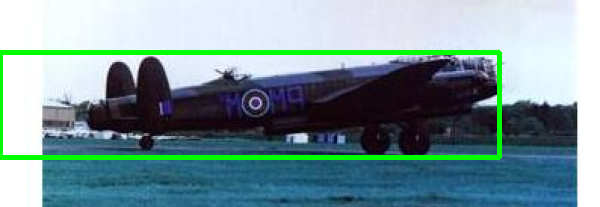

In [ ]:
import imutils

image=cv2.imread(imagepath)
image=imutils.resize(image,width=600)
(h,w)=image.shape[:2]

startX=int(startX * w)
startY=int(startY * h)
endX=int(endX * w)
endY=int(endY * h)

cv2.rectangle(image,(startX,startY),(endX,endY),(0,255,0),3)

-1

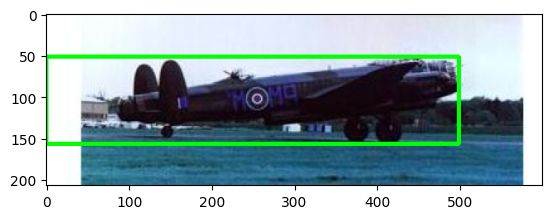

In [ ]:
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

plt.imshow(image)
cv2.waitKey(0)